<a href="https://colab.research.google.com/github/sezaionurlu/Customer-Segmentation-with-Online-Retail-RFM-Analysis/blob/main/Online_Retail_RFM_Analizi_%C4%B0le_M%C3%BC%C5%9Fteri_Segmentasyonu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##############################################################
# Online Retail RFM Analizi İle Müşteri Segmentasyonu
##############################################################

**İş Problemi**

İngiltere merkezli perakende şirketi müşterilerini
segmentlere ayırıp bu segmentlere göre pazarlama
stratejileri belirlemek istemektedir.
Ortak davranışlar sergileyen müşteri segmentleri özelinde
pazarlama çalışmaları yapmanın gelir artışı sağlayacağını
düşünmektedir.
Segmentlere ayırmak için RFM analizi kullanılacaktır.

**Veri Seti Hikayesi**

Online Retail II isimli veri seti İngiltere merkezli bir perakende şirketinin 01/12/2009 - 09/12/2011 tarihleri
arasındaki online satış işlemlerini içeriyor. Şirketin ürün kataloğunda hediyelik eşyalar yer almaktadır ve çoğu
müşterisinin toptancı olduğu bilgisi mevcuttur.

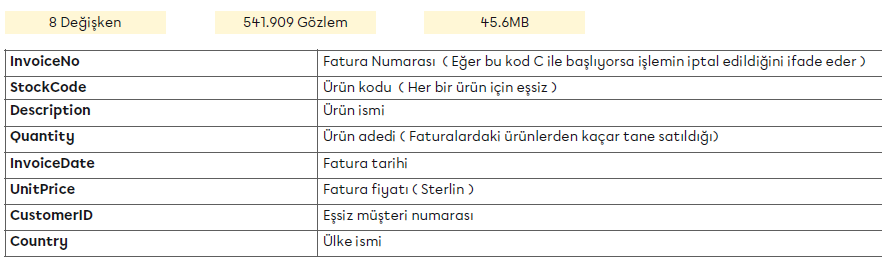

**Proje Görevleri**

In [ ]:
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


*Görev 1: Veriyi Anlama ve Hazırlama*

In [ ]:
# Adım 1: Online Retail II excelindeki 2010-2011 verisini okuyunuz. Oluşturduğunuz dataframe’in kopyasını oluşturunuz.

In [ ]:
df_ = pd.read_excel('/content/drive/MyDrive/Veri Bilimi/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [ ]:
df = df_.copy()

In [ ]:
# Adım 2: Veri setinin betimsel istatistiklerini inceleyiniz.

In [ ]:
df.shape

(541910, 8)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# Adım3: Veri setinde eksik gözlem var mı? Varsa hangi değişkende kaç tane eksik gözlem vardır?

In [ ]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [ ]:
# Adım4: Eksik gözlemleri veri setinden çıkartınız. Çıkarma işleminde ‘inplace=True’ parametresini kullanınız.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
# Adım5: Eşsiz ürün sayısı kaçtır?

In [ ]:
df['StockCode'].nunique()

3684

In [ ]:
# Adım6: Hangi üründen kaçar tane vardır?

In [ ]:
df['StockCode'].value_counts()

85123A    2077
22423     1905
85099B    1662
84879     1418
47566     1416
          ... 
84620        1
90038B       1
90038C       1
84614A       1
20957        1
Name: StockCode, Length: 3684, dtype: int64

In [ ]:
# Adım7: En çok sipariş edilen 5 ürünü çoktan aza doğru sıralayınız

In [ ]:
df.groupby('StockCode').agg({'Quantity':'sum'}).sort_values('Quantity', ascending=False).head()

,Quantity
StockCode,
84077,53215
22197,48712
85099B,45066
84879,35314
85123A,34204


In [ ]:
# Adım 8: Faturalardaki ‘C’ iptal edilen işlemleri göstermektedir. İptal edilen işlemleri veri setinden çıkartınız.

In [ ]:
df.loc[df['Invoice'].str.contains('C', na=False),:]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.5000,14527.0000,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.6500,15311.0000,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.6500,17548.0000,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.2900,17548.0000,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.2900,17548.0000,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.8300,14397.0000,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.6900,15498.0000,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.9500,15311.0000,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.2500,17315.0000,United Kingdom


In [ ]:
df = df.loc[~df['Invoice'].str.contains('C', na=False),:]

In [ ]:
# Adım 9: Fatura başına elde edilen toplam kazancı ifade eden ‘TotalPrice’ adında bir değişken oluşturunuz

In [ ]:
df['TotalPrice'] = df['Quantity'] * df['Price']

*Görev 2: RFM Metriklerinin Hesaplanması*

**DİKKAT!**

recency değeri için bugünün tarihini (2011, 12, 11) olarak kabul ediniz.
rfm dataframe’ini oluşturduktan sonra veri setini "monetary>0" olacak şekilde filtreleyiniz.

In [ ]:
# Adım 1: Recency, Frequency ve Monetary tanımlarını yapınız.

In [ ]:
# Recency: Son satınalmadan sonra geçen süre
# Frequency: Kaç defa satınalma yaptığı
# Monetary: Toplam bıraktığı parasal değer

In [ ]:
# Adım 2: Müşteri özelinde Recency, Frequency ve Monetary metriklerini groupby, agg ve lambda ile hesaplayınız.

In [ ]:
today_date = dt.datetime(2011, 12, 11)

In [ ]:
df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days, 
                               'Invoice': lambda x: x.sum(),
                               'TotalPrice': lambda x: x.sum()})

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0000,326,541431,77183.6000
12347.0000,3,101296926,4310.0000
12348.0000,76,16869685,1797.2400
12349.0000,19,42165457,1757.5500
12350.0000,311,9231629,334.4000
...,...,...,...
18280.0000,278,5457120,180.6000
18281.0000,181,3895248,80.8200
18282.0000,8,6838540,178.0500


In [ ]:
# Adım 3: Hesapladığınız metrikleri rfm isimli bir değişkene atayınız.

In [ ]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days, 
                               'Invoice': lambda x: x.sum(),
                               'TotalPrice': lambda x: x.sum()})

In [ ]:
# Adım4: Oluşturduğunuz metriklerin isimlerini recency, frequency ve monetary olarak değiştiriniz.

In [ ]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [ ]:
rfm = rfm.loc[rfm['monetary']>0,:]

In [ ]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,93.0595,100.0123,1.0000,18.0000,51.0000,142.7500,374.0000
frequency,4338.0000,51425314.0270,128793858.6634,536393.0000,9559714.7500,23141986.0000,56319680.7500,4418581314.0000
monetary,4338.0000,2054.2706,8989.2299,3.7500,307.4150,674.4850,1661.7400,280206.0200


*Görev 3: RFM Skorlarının Oluşturulması ve Tek bir Değişkene Çevrilmesi*

In [ ]:
# Adım 1: Recency, Frequency ve Monetary metriklerini qcut yardımı ile 1-5 arasında skorlara çeviriniz.

In [ ]:
pd.qcut(rfm['recency'], 5, labels = [5, 4, 3, 2, 1])
pd.qcut(rfm['frequency'], 5, labels = [1, 2 ,3 ,4 ,5])
pd.qcut(rfm['monetary'], 5, labels = [1, 2 ,3 ,4 ,5])

Customer ID
12346.0000    5
12347.0000    5
12348.0000    4
12349.0000    4
12350.0000    2
             ..
18280.0000    1
18281.0000    1
18282.0000    1
18283.0000    5
18287.0000    4
Name: monetary, Length: 4338, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [ ]:
# Adım 2: Bu skorları recency_score, frequency_score ve monetary_score olarak kaydediniz.

In [ ]:
rfm['recency_score'] = pd.qcut(rfm['recency'], 5, labels = [5, 4, 3, 2, 1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'], 5, labels = [1, 2 ,3 ,4 ,5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels = [1, 2 ,3 ,4 ,5])

In [ ]:
# Adım 3: recency_score ve frequency_score’u tek bir değişken olarak ifade ediniz ve RF_SCORE olarak kaydediniz.

In [ ]:
rfm['RF_SCORE'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)

In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE
Customer ID,,,,,,,
12346.0000,326,541431,77183.6000,1,1,5,11
12347.0000,3,101296926,4310.0000,5,5,5,55
12348.0000,76,16869685,1797.2400,2,3,4,23
12349.0000,19,42165457,1757.5500,4,4,4,44
12350.0000,311,9231629,334.4000,1,2,2,12


*Görev 4: RF Skorunun Segment Olarak Tanımlanması*

In [ ]:
# Adım 1: Oluşturulan RF skorları için segment tanımlamaları yapınız.

In [ ]:
# Adım 2: Aşağıdaki seg_map yardımı ile skorları segmentlere çeviriniz.

In [ ]:
seg_map = {
    r'[1-2][1-2]':'hibernating',
    r'[1-2][3-4]':'at_Risk',
    r'[1-2]5':'cant_loose',
    r'3[1-2]':'about_to_sleep',
    r'33':'need_attention',
    r'[3-4][4-5]':'loyal_customers',
    r'41':'promising',
    r'51':'new_customers',
    r'[4-5][2-3]':'potential_loyalists',
    r'5[4-5]':'champions',
}

In [ ]:
rfm['segment'] = rfm['RF_SCORE'].replace(seg_map, regex=True)

In [ ]:
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RF_SCORE,segment
Customer ID,,,,,,,,
12346.0000,326,541431,77183.6000,1,1,5,11,hibernating
12347.0000,3,101296926,4310.0000,5,5,5,55,champions
12348.0000,76,16869685,1797.2400,2,3,4,23,at_Risk
12349.0000,19,42165457,1757.5500,4,4,4,44,loyal_customers
12350.0000,311,9231629,334.4000,1,2,2,12,hibernating


*Görev 5: Aksiyon Zamanı !*

In [ ]:
# Adım1: Önemli gördüğünü 3 segmenti seçiniz. Bu üç segmenti hem aksiyon kararları açısından hemde segmentlerin yapısı açısından(ortalama
# RFM değerleri) yorumlayınız.

In [ ]:
rfm_onemli = rfm.loc[rfm['segment'].isin(['champions','loyal_customers', 'cant_loose']),:]

In [ ]:
rfm_onemli.groupby('segment').agg({'recency':'mean',
                                   'frequency':'mean',
                                   'monetary':'mean'})

,recency,frequency,monetary
segment,,,
cant_loose,144.8902,101003183.9268,2379.0855
champions,6.4344,161691774.0377,6919.8298
loyal_customers,34.2260,87660316.7618,2827.1651


In [ ]:
# Adım2: "Loyal Customers" sınıfına ait customer ID'leri seçerek excel çıktısını alınız.

In [ ]:
rfm_loyal = rfm_onemli.loc[rfm['segment'] == 'loyal_customers', :]

In [ ]:
rfm_loyal['segment'].value_counts()

loyal_customers    823
Name: segment, dtype: int64

In [ ]:
rfm_loyal.to_excel('output_xlsx', engine='openpyxl')

In [ ]:
?rfm.to_excel